In [26]:
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

import pandas as pd
import numpy as np
import random
import scipy.misc
from google.colab import drive 

import seaborn as sns
import librosa
import librosa.display
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab import drive 
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
tf.random.set_seed(12345)
np.random.seed(12345)
import pickle
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DRIVE_FOLDER = '/content/drive/My Drive/data/false/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
false_dict = {'name':[]}
for file in entries:

    false_dict['name'].append(file)
DRIVE_FOLDER = '/content/drive/My Drive/data/true/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
true_dict = {'name':[]}
for file in entries:

    true_dict['name'].append(file)

In [4]:
df1 = pd.DataFrame(false_dict)
df1['label'] = 0
df1['path'] = '/content/drive/My Drive/data/false/'
print('The number of false labels is: ', df1.shape[0])
df2 = pd.DataFrame(true_dict)
df2['label'] = 1
df2['path'] = '/content/drive/My Drive/data/true/'
print('The number of true labels is: ', df2.shape[0])
# combine both dataframes
df = pd.concat([df1,df2])
df = df.sample(frac=1, random_state=56).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

labels = df['label'].unique()
df.head

The number of false labels is:  826
The number of true labels is:  826
The length of the dataset is:  1,652


<bound method NDFrame.head of                        name  label                                 path
0         Mani_false423.wav      0  /content/drive/My Drive/data/false/
1         Mani_false490.wav      0  /content/drive/My Drive/data/false/
2               Mani259.wav      1   /content/drive/My Drive/data/true/
3     Mani_false510 (1).wav      0  /content/drive/My Drive/data/false/
4          Mani_false77.wav      0  /content/drive/My Drive/data/false/
...                     ...    ...                                  ...
1647            Mani658.wav      1   /content/drive/My Drive/data/true/
1648        Maninoise73.wav      1   /content/drive/My Drive/data/true/
1649        Mani644 (1).wav      1   /content/drive/My Drive/data/true/
1650      Mani_false590.wav      0  /content/drive/My Drive/data/false/
1651      Mani_false868.wav      0  /content/drive/My Drive/data/false/

[1652 rows x 3 columns]>

In [5]:
train, test = train_test_split(df, test_size=0.15, random_state =12345)

In [ ]:
l = ['false','true']
def get_images(df_in):
    for i in tqdm(range(0,df_in.shape[0])):
   
    
      y , sr = librosa.load(df_in.iloc[i][2] + df_in.iloc[i][0])
      fig,ax = plt.subplots(1)
      fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
      ax.axis('off')
      pxx, freqs, bins, im = ax.specgram(x = y, Fs= sr, noverlap=384, NFFT=512)
      ax.axis('off')
      fig.savefig('/content/drive/MyDrive/data/train/c' +str(df_in.iloc[i][1])+'/'+l[int(df_in.iloc[i][1])] + str(i)+'.png', dpi=300, frameon='false')

get_images(train)


In [ ]:
l = ['false','true']
def get_images(df_in):
    for i in tqdm(range(0,df_in.shape[0])):
   
    
      y , sr = librosa.load(df_in.iloc[i][2] + df_in.iloc[i][0])
      fig,ax = plt.subplots(1)
      fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
      ax.axis('off')
      pxx, freqs, bins, im = ax.specgram(x = y, Fs= sr, noverlap=384, NFFT=512)
      ax.axis('off')
      fig.savefig('/content/drive/MyDrive/data/test/c' +str(df_in.iloc[i][1])+'/'+l[int(df_in.iloc[i][1])] + str(i)+'.png', dpi=300, frameon='false')

get_images(test)

In [8]:
train_path = '/content/drive/My Drive/data/train/'
test_path = '/content/drive/My Drive/data/test/'

In [9]:
batch_size = 50
validation_split = 0.2
seed = 1234
h = 64
w = 64
c = 3

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_data = train_datagen.flow_from_directory(train_path, target_size= (h,w), batch_size=batch_size, subset='training', seed=seed)

Found 1746 images belonging to 2 classes.


In [16]:
valid_data = train_datagen.flow_from_directory(train_path, target_size= (h,w), batch_size=batch_size, subset='validation', shuffle = False, seed=seed)

Found 436 images belonging to 2 classes.


In [37]:
test_data = test_datagen.flow_from_directory(test_path, target_size= (h,w), batch_size=batch_size, shuffle = False, seed=seed)

Found 248 images belonging to 2 classes.


In [27]:
#Model CNN

model_dir = '/content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), strides=1,padding='Same', activation='relu', input_shape=(h,w,c), data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2, 2)))




model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer= Adam(learning_rate=0.0001),metrics=['accuracy', tf.keras.metrics.AUC()])

In [28]:
n_epochs = 25

In [29]:
history = model.fit(train_data,  epochs = n_epochs, validation_data = valid_data,  callbacks=[checkpoint,es], verbose = 1)

Epoch 1/25
35/35 [==============================] - ETA: 0s - loss: 0.8400 - accuracy: 0.5584 - auc_3: 0.5800
Epoch 1: val_accuracy improved from -inf to 0.72477, saving model to /content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5
35/35 [==============================] - 249s 7s/step - loss: 0.8400 - accuracy: 0.5584 - auc_3: 0.5800 - val_loss: 0.5922 - val_accuracy: 0.7248 - val_auc_3: 0.7915
Epoch 2/25
35/35 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.7566 - auc_3: 0.8489
Epoch 2: val_accuracy did not improve from 0.72477
35/35 [==============================] - 222s 6s/step - loss: 0.5072 - accuracy: 0.7566 - auc_3: 0.8489 - val_loss: 0.4722 - val_accuracy: 0.6950 - val_auc_3: 0.8394
Epoch 3/25
35/35 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8551 - auc_3: 0.9349
Epoch 3: val_accuracy improved from 0.72477 to 0.87615, saving model to /content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history

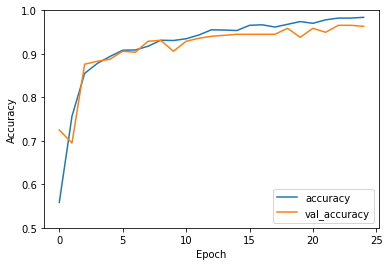

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

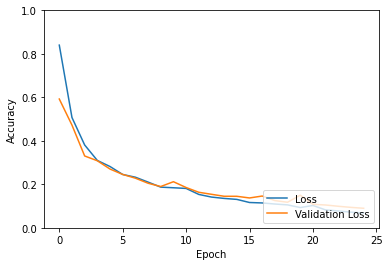

In [31]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

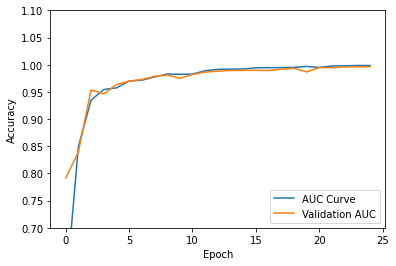

In [32]:
plt.plot(history.history['auc_3'], label='AUC Curve')
plt.plot(history.history['val_auc_3'], label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.1])
plt.legend(loc='lower right')

In [33]:
model_saved = load_model('/content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history.h5')

In [38]:
y_pred = model_saved.predict(test_data, verbose=1)


y_pred = np.argmax(y_pred, axis=1)

y_test = test_data.labels

5/5 [==============================] - 29s 6s/step


In [39]:
loss, acc, auc = model_saved.evaluate(test_data)
print(acc)

5/5 [==============================] - 25s 5s/step - loss: 0.1560 - accuracy: 0.9435 - auc_3: 0.9851
0.9435483813285828


Accuracy Score is : 94.35%
 
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       125
           1       0.94      0.94      0.94       123

    accuracy                           0.94       248
   macro avg       0.94      0.94      0.94       248
weighted avg       0.94      0.94      0.94       248

 


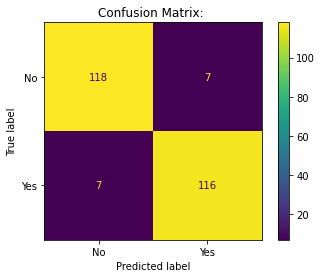

In [40]:
accuracy = accuracy_score(y_pred, y_test) 
print("Accuracy Score is : " + "{:.2%}".format(accuracy))
print(' ')
cm = confusion_matrix(y_pred, y_test, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    
disp.plot()
plt.title('Confusion Matrix: ')

print("Classification Report:")
print(classification_report(y_pred, y_test, labels=[0, 1], zero_division=1))
print(" ")
plt.show()

In [41]:
model.save('/content/drive/MyDrive/Spotify/trained_models/spotify_CNN_keras_history_v2.h5')